# Precipitation-driven in warmer and smoothed soundings

Thomas Schanzer  
February 2022

In this notebook, we investigate changes in precipitation-driven downdraft characteristics when the previously used soundings are made warmer or more smooth.

In [132]:
import sys
import shelve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from siphon.simplewebservice.wyoming import WyomingUpperAir

from scipy.interpolate import interp1d
from scipy.signal import argrelmin
from scipy.ndimage import gaussian_filter1d

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

from dparcel.thermo import (saturation_specific_humidity,
                            equivalent_potential_temperature)

sys.path.append('../convection_scheme')
from coupler import CoupledThermalGenerator

In [65]:
# fixed parameters
thickness = 2*units.km
t_pert = 1*units.delta_degC
l_crit = 2e-3*units.dimensionless
drag_up, drag_down = 0/units.km, 0/units.km
l_initial = 0*units.dimensionless
w_initial = 0*units.meter/units.second
epsilon_down = np.arange(0.05, 0.601, 0.02)*(1/units.km)
epsilon_up = [0.1, 0.3, 0.5]*(1/units.km)
dnu_db = 0*units.second**2/units.meter**2

## Helper functions

In [174]:
def downdraft_init_levels(generator, thickness):
    """Get initiation and precipitation top levels for downdrafts."""
    i_init_down_min = np.min(np.argwhere(generator.height <= 4000*units.meter))
    i_init_down_max = np.max(np.argwhere(generator.height >= 500*units.meter))
    i_init_down = range(i_init_down_min, i_init_down_max+1, 2)
    z_init_down = generator.height[i_init_down_min:i_init_down_max+1:2]
    i_precip_top = np.argmin(np.abs(
        np.atleast_2d(generator.height)
        - np.atleast_2d(z_init_down + thickness).T
    ), axis=1)
    return i_init_down, z_init_down, i_precip_top

In [175]:
def run_updraft(generator, t_pert, l_crit, epsilon_up, drag_up):
    """Run the updraft calculation."""
    i_init_up = generator.pressure.size - 1
    q_pert = (
        saturation_specific_humidity(
            generator.pressure[i_init_up], generator.temperature[i_init_up])
         - generator.specific_humidity[i_init_up]
    )/1.5
    updraft = generator.updraft(
        i_init_up, t_pert, q_pert, l_initial, w_initial,
        epsilon_up, dnu_db, drag_up, l_crit, basic=True)
    return updraft

In [176]:
def get_total_precip(updraft, i_init_down, i_precip_top):
    """Calculate total precipitation."""
    total_precip = np.zeros(len(i_init_down))*units('')
    for i in range(len(i_init_down)):
        total_precip[i] = np.nansum((
            updraft.precipitation*updraft.m_remaining
        )[i_precip_top[i] : i_init_down[i] + 1])
    return total_precip

In [177]:
def run_downdrafts(generator, i_init_down, total_precip, drag_down):
    """Run the downdraft calculations."""
    downdrafts = np.zeros((len(i_init_down), epsilon_down.size),
                          dtype='object')
    n_calc = epsilon_down.size*len(i_init_down)
    n_done = 0
    for i in range(len(i_init_down)):
        for j in range(epsilon_down.size):
            n_done += 1
            sys.stdout.write(f'\r        Calculation {n_done} of {n_calc}    ')
            downdrafts[i,j] = generator.precipitation_downdraft(
                i_init_down[i], total_precip[i], w_initial,
                epsilon_down[j], dnu_db, drag_down, basic=True)
    sys.stdout.write('\n')
    return downdrafts

In [178]:
def get_downdraft_data(generator, downdrafts):
    """Find max downdraft velocity and min height."""
    max_velocity = np.zeros(downdrafts.shape)*units('m/s')
    max_velocity_height = np.zeros(downdrafts.shape)*units.meter
    min_height = np.zeros(downdrafts.shape)*units.meter

    for i in range(downdrafts.shape[0]):
        for j in range(downdrafts.shape[1]):
            max_velocity_i = np.nanargmin(downdrafts[i,j].velocity)
            max_velocity[i,j] = downdrafts[i,j].velocity[max_velocity_i]
            max_velocity_height[i,j] = generator.height[max_velocity_i]
            min_height_i = np.max(
                np.argwhere(~np.isnan(downdrafts[i,j].velocity)))
            min_height[i,j] = generator.height[min_height_i]
            
    return max_velocity, max_velocity_height, min_height

In [179]:
def multiple_downdraft_runs(
        generator, name, thickness, t_pert, l_crit, drag_up, drag_down):
    """Do a downdraft run for each updraft entrainment rate."""
    print('Starting run ' + name + ' ...')
    
    (i_init_down,
     z_init_down,
     i_precip_top) = downdraft_init_levels(generator, thickness)
    theta_e = equivalent_potential_temperature(
        generator.pressure, generator.temperature, generator.specific_humidity)
    z_min_theta_e = generator.height[np.argmin(theta_e)]
    
    w_max_all = []
    z_w_max_all = []
    z_min_all = []
    z_max_evap_all = []
    
    for eps in epsilon_up:
        print('    epsilon_up = {:.2f} /km ...'.format(eps.m))
        updraft = run_updraft(generator, t_pert, l_crit, eps, drag_up)
        total_precip = get_total_precip(updraft, i_init_down, i_precip_top)
        downdrafts = run_downdrafts(
            generator, i_init_down, total_precip, drag_down)
        w_max, z_w_max, z_min = get_downdraft_data(generator, downdrafts)
        z_max_evap = z_init_down[np.argmax(total_precip, axis=0)]
        
        w_max_all.append(w_max)
        z_w_max_all.append(z_w_max)
        z_min_all.append(z_min)
        z_max_evap_all.append(z_max_evap)
        
    with shelve.open('generalising_coupling_data/' + name) as db:
        db['z_init_down'] = z_init_down
        db['z_min_theta_e'] = z_min_theta_e
        db['z_max_evap'] = z_max_evap_all
        db['w_max'] = w_max_all
        db['z_w_max'] = z_w_max_all
        db['z_min'] = z_min_all

## Creating warmer soundings with the same CAPE
Rather than simply adding 5 K to the temperature profile, we first compute the profiles of the original surface parcel and one whose initial temperature is 5 K warmer (with the same RH), then shift the temperature profile such that the difference between the new environmental temperature and parcel profile is the same at every level as in the original sounding. This ensures that the CAPE is unchanged.

### Singapore sounding

In [49]:
df = WyomingUpperAir.request_data(datetime(2021, 12, 1, 0), '48698')
df = df.dropna().drop(range(3))
sounding = df[['pressure', 'height', 'temperature', 'dewpoint']].to_numpy()

pressure_raw = sounding[:,0]
height_raw = sounding[:,1]
height_raw -= np.min(height_raw)
temperature_raw = sounding[:,2]
dewpoint_raw = sounding[:,3]

pressure = np.arange(pressure_raw[0], pressure_raw[-1], -5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)

singapore = CoupledThermalGenerator(
    np.flip(pressure), np.flip(height), np.flip(temperature),
    np.flip(specific_humidity))

In [28]:
original_profile = mpcalc.parcel_profile(pressure, temperature[0], dewpoint[0])
t_sfc_new = temperature[0] + 5*units.delta_degC
rh_orig = mpcalc.relative_humidity_from_dewpoint(temperature, dewpoint)

td_sfc_new = mpcalc.dewpoint_from_relative_humidity(t_sfc_new, rh_orig[0])
new_profile = mpcalc.parcel_profile(pressure, t_sfc_new, td_sfc_new)
new_temperature = (temperature.to(units.kelvin)
                   + new_profile.to(units.kelvin)
                   - original_profile.to(units.kelvin))
new_dewpoint = mpcalc.dewpoint_from_relative_humidity(new_temperature, rh_orig)

original_cape, original_cin = mpcalc.cape_cin(
    pressure, temperature, dewpoint, original_profile)
print(original_cape, original_cin)
new_cape, new_cin = mpcalc.cape_cin(
    pressure, new_temperature, new_dewpoint, new_profile)
print(new_cape, new_cin)

new_specific_humidity = mpcalc.specific_humidity_from_dewpoint(
    pressure, new_dewpoint)
singapore_warmer = CoupledThermalGenerator(
    np.flip(pressure), np.flip(height), np.flip(new_temperature),
    np.flip(new_specific_humidity))

2767.636922806763 joule / kilogram -11.116187378631047 joule / kilogram
2767.6369228067624 joule / kilogram -11.116187378631052 joule / kilogram


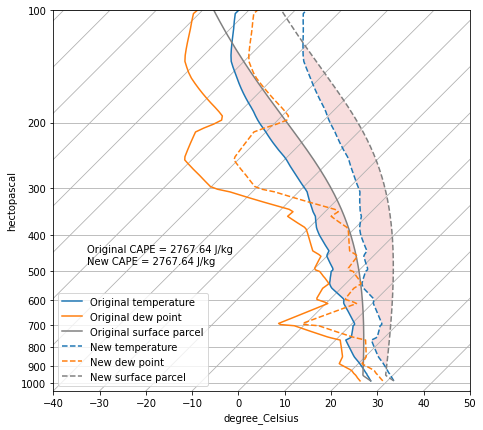

In [29]:
fig = plt.figure(figsize=(8,7))
skew = SkewT(fig, rotation=45)
skew.plot(pressure, temperature, label='Original temperature')
skew.plot(pressure, dewpoint, label='Original dew point')
skew.plot(pressure, original_profile, '0.5', label='Original surface parcel')
skew.shade_cape(pressure, temperature, original_profile, alpha=0.15)
skew.plot(pressure, new_temperature, color='tab:blue', linestyle='--',
          label='New temperature')
skew.plot(pressure, new_dewpoint, color='tab:orange', linestyle='--',
          label='New dew point')
skew.plot(pressure, new_profile, '0.5', linestyle='--',
          label='New surface parcel')
skew.shade_cape(pressure, new_temperature, new_profile, alpha=0.15)
text = ('Original CAPE = {:.2f} J/kg'
        '\nNew CAPE = {:.2f} J/kg').format(original_cape.m, new_cape.m)
skew.ax.text(-60, 480, text)
skew.ax.legend()

In [68]:
%%time
multiple_downdraft_runs(
    singapore_warmer, 'singapore_5K_warmer_same_CAPE',
    thickness, t_pert, l_crit, drag_up, drag_down)

Starting run singapore_5K_warmer_same_CAPE ...
    epsilon_up = 0.10 /km ...
        Calculation 896 of 896    
    epsilon_up = 0.30 /km ...
        Calculation 896 of 896    
    epsilon_up = 0.50 /km ...
        Calculation 896 of 896    
CPU times: user 5min 30s, sys: 1.52 s, total: 5min 32s
Wall time: 5min 31s


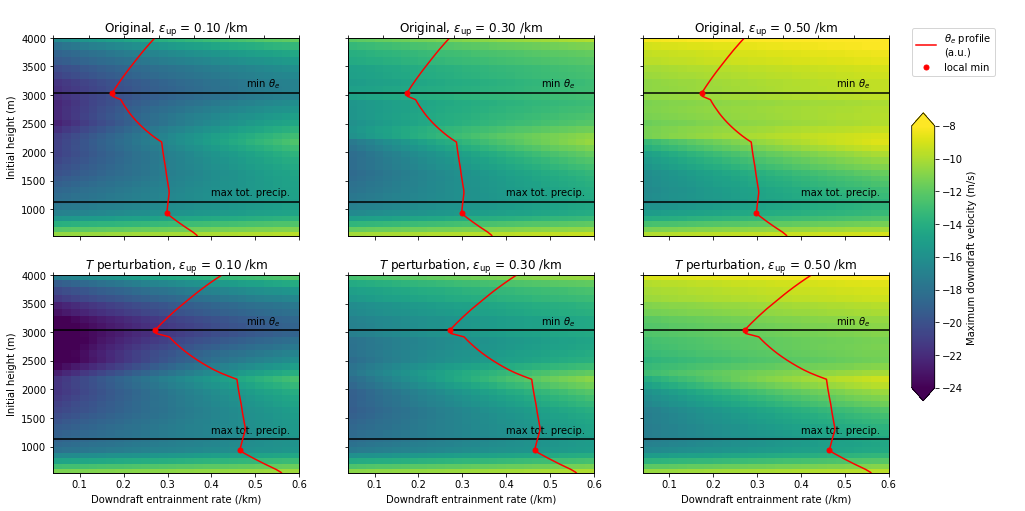

In [74]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for i, name in enumerate(
        ['singapore', 'singapore_5K_warmer_same_CAPE']):
    db = shelve.open('generalising_coupling_data/' + name)
    sounding = {'singapore': singapore,
                'singapore_5K_warmer_same_CAPE': singapore_warmer}[name]
    theta_e = equivalent_potential_temperature(
        sounding.pressure, sounding.temperature, sounding.specific_humidity)
    i_relmin_theta_e = argrelmin(theta_e, order=4)
    for j, eps in enumerate(epsilon_up):
        mesh = axes[i,j].pcolormesh(
            epsilon_down, db['z_init_down'], db['w_max'][j], shading='nearest')
        mesh.set_clim(-24, -8)
        
        axes[i,j].axhline(db['z_max_evap'][j].m, color='k')
        axes[i,j].text(0.4, db['z_max_evap'][j].m + 100, 'max tot. precip.')
        axes[i,j].axhline(db['z_min_theta_e'].m, color='k',
                          label='min $\\theta_e$')
        axes[i,j].text(0.48, db['z_min_theta_e'].m + 100,
                       'min $\\theta_e$', color='k')
        
        ax = axes[i,j].twiny()
        ax.plot(theta_e, sounding.height,
                label='$\\theta_e$ profile\n(a.u.)', color='r')
        ax.plot(theta_e[i_relmin_theta_e], sounding.height[i_relmin_theta_e],
                'r.', markersize=10, label='local min')
        ax.set_xlim(310, 380)
        ax.set_xlabel('')
        ax.set_xticklabels([])
        
        title = ({'singapore': 'Original',
                  'singapore_5K_warmer_same_CAPE': '$T$ perturbation'}[name]
                 + ', $\\epsilon_\\mathrm{{up}}$ = {:.2f} /km'.format(eps.m))
        axes[i,j].set(xlabel='Downdraft entrainment rate (/km)',
                      ylabel='Initial height (m)',
                      title=title)
        axes[i,j].set_ylim(540, 4000)
    db.close()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.89, 0.85))
    
for ax in axes[:,1:].ravel():
    ax.set_ylabel('')
    ax.set_yticklabels([])
for ax in axes[:-1,:].ravel():
    ax.set_xlabel('')
    ax.set_xticklabels([])
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.25, 0.02, 0.5])
cbar = fig.colorbar(mesh, cax=cbar_ax, extend='both')
cbar.set_label('Maximum downdraft velocity (m/s)')

# fig.tight_layout()

### Hilo sounding

In [181]:
df = WyomingUpperAir.request_data(datetime(2021, 12, 7, 0), '91285')
df = df.dropna()
sounding = df[['pressure', 'height', 'temperature', 'dewpoint']].to_numpy()

pressure_raw = sounding[:,0]
height_raw = sounding[:,1]
height_raw -= np.min(height_raw)
temperature_raw = sounding[:,2]
dewpoint_raw = sounding[:,3]

pressure = np.arange(pressure_raw[0], pressure_raw[-1], -5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)

hilo = CoupledThermalGenerator(
    np.flip(pressure), np.flip(height), np.flip(temperature),
    np.flip(specific_humidity))

In [33]:
original_profile = mpcalc.parcel_profile(pressure, temperature[0], dewpoint[0])
t_sfc_new = temperature[0] + 5*units.delta_degC
rh_orig = mpcalc.relative_humidity_from_dewpoint(temperature, dewpoint)

td_sfc_new = mpcalc.dewpoint_from_relative_humidity(t_sfc_new, rh_orig[0])
new_profile = mpcalc.parcel_profile(pressure, t_sfc_new, td_sfc_new)
new_temperature = (temperature.to(units.kelvin)
                   + new_profile.to(units.kelvin)
                   - original_profile.to(units.kelvin))
new_dewpoint = mpcalc.dewpoint_from_relative_humidity(new_temperature, rh_orig)

original_cape, original_cin = mpcalc.cape_cin(
    pressure, temperature, dewpoint, original_profile)
print(original_cape, original_cin)
new_cape, new_cin = mpcalc.cape_cin(
    pressure, new_temperature, new_dewpoint, new_profile)
print(new_cape, new_cin)

new_specific_humidity = mpcalc.specific_humidity_from_dewpoint(
    pressure, new_dewpoint)
hilo_warmer = CoupledThermalGenerator(
    np.flip(pressure), np.flip(height), np.flip(new_temperature),
    np.flip(new_specific_humidity))

2212.822017742392 joule / kilogram -0.8139252148881307 joule / kilogram
2212.8220177423914 joule / kilogram -0.8139252148881224 joule / kilogram


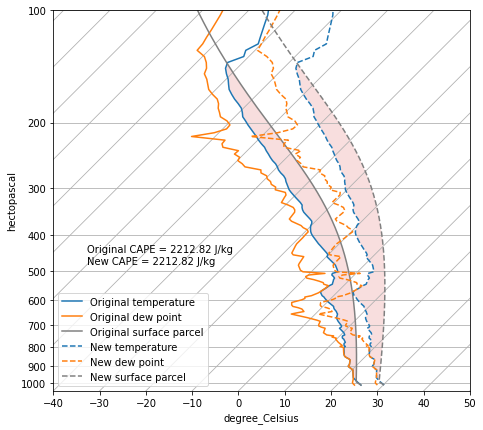

In [34]:
fig = plt.figure(figsize=(8,7))
skew = SkewT(fig, rotation=45)
skew.plot(pressure, temperature, label='Original temperature')
skew.plot(pressure, dewpoint, label='Original dew point')
skew.plot(pressure, original_profile, '0.5', label='Original surface parcel')
skew.shade_cape(pressure, temperature, original_profile, alpha=0.15)
skew.plot(pressure, new_temperature, color='tab:blue', linestyle='--',
          label='New temperature')
skew.plot(pressure, new_dewpoint, color='tab:orange', linestyle='--',
          label='New dew point')
skew.plot(pressure, new_profile, '0.5', linestyle='--',
          label='New surface parcel')
skew.shade_cape(pressure, new_temperature, new_profile, alpha=0.15)
text = ('Original CAPE = {:.2f} J/kg'
        '\nNew CAPE = {:.2f} J/kg').format(original_cape.m, new_cape.m)
skew.ax.text(-60, 480, text)
skew.ax.legend()

In [43]:
%%time
multiple_downdraft_runs(
    hilo_warmer, 'hilo_5K_warmer_same_CAPE',
    thickness, t_pert, l_crit, drag_up, drag_down)

Starting run hilo_5K_warmer_same_CAPE ...
    epsilon_up = 0.10 /km ...
        Calculation 924 of 924    
    epsilon_up = 0.30 /km ...
        Calculation 924 of 924    
    epsilon_up = 0.50 /km ...
        Calculation 924 of 924    
CPU times: user 5min 49s, sys: 1.75 s, total: 5min 51s
Wall time: 5min 51s


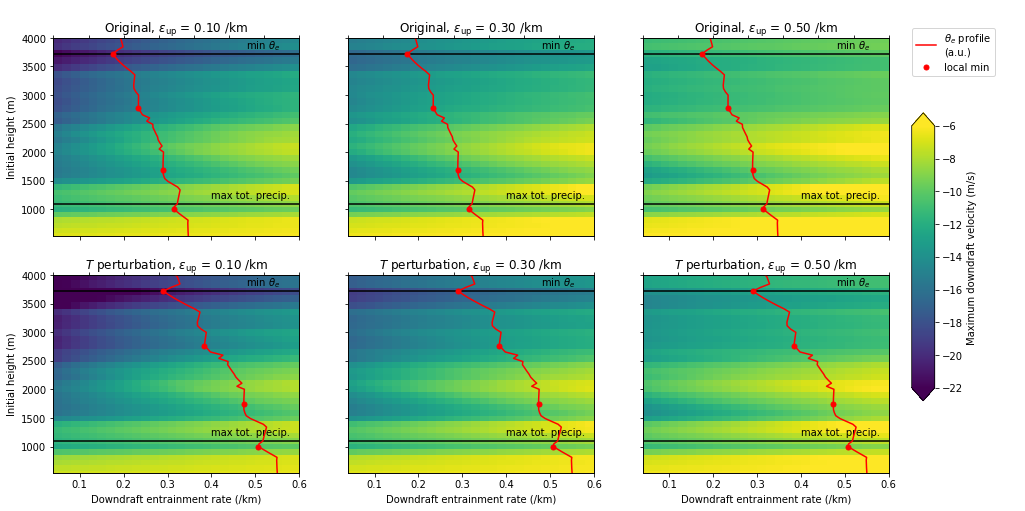

In [46]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for i, name in enumerate(
        ['hilo', 'hilo_5K_warmer_same_CAPE']):
    db = shelve.open('generalising_coupling_data/' + name)
    sounding = {'hilo': hilo,
                'hilo_5K_warmer_same_CAPE': hilo_warmer}[name]
    theta_e = equivalent_potential_temperature(
        sounding.pressure, sounding.temperature, sounding.specific_humidity)
    i_relmin_theta_e = argrelmin(theta_e, order=4)
    for j, eps in enumerate(epsilon_up):
        mesh = axes[i,j].pcolormesh(
            epsilon_down, db['z_init_down'], db['w_max'][j], shading='nearest')
        mesh.set_clim(-22, -6)
        
        axes[i,j].axhline(db['z_max_evap'][j].m, color='k')
        axes[i,j].text(0.4, db['z_max_evap'][j].m + 100, 'max tot. precip.')
        axes[i,j].axhline(db['z_min_theta_e'].m, color='k',
                          label='min $\\theta_e$')
        axes[i,j].text(0.48, db['z_min_theta_e'].m + 100,
                       'min $\\theta_e$', color='k')
        
        ax = axes[i,j].twiny()
        ax.plot(theta_e, sounding.height,
                label='$\\theta_e$ profile\n(a.u.)', color='r')
        ax.plot(theta_e[i_relmin_theta_e], sounding.height[i_relmin_theta_e],
                'r.', markersize=10, label='local min')
        ax.set_xlim(310, 380)
        ax.set_xlabel('')
        ax.set_xticklabels([])
        
        title = ({'hilo': 'Original',
                  'hilo_5K_warmer_same_CAPE': '$T$ perturbation'}[name]
                 + ', $\\epsilon_\\mathrm{{up}}$ = {:.2f} /km'.format(eps.m))
        axes[i,j].set(xlabel='Downdraft entrainment rate (/km)',
                      ylabel='Initial height (m)',
                      title=title)
        axes[i,j].set_ylim(540, 4000)
    db.close()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.89, 0.85))
    
for ax in axes[:,1:].ravel():
    ax.set_ylabel('')
    ax.set_yticklabels([])
for ax in axes[:-1,:].ravel():
    ax.set_xlabel('')
    ax.set_xticklabels([])
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.25, 0.02, 0.5])
cbar = fig.colorbar(mesh, cax=cbar_ax, extend='both')
cbar.set_label('Maximum downdraft velocity (m/s)')

# fig.tight_layout()

### Discussion
Ensuring the CAPE is unchanged does not affect our conclusion; the downdraft strength is increased by a similar amount everywhere in the warmer sounding, with maxima appearing at the same initiation levels.

## Smoothed soundings
We now attempt to remove artifacts or noise in the soundings that might have been introduced by imperfect data acquisition. We apply a gaussian filter to the $\theta_e$ and specific humidity profiles, then use these to re-compute the temperature profile.

In [138]:
def smooth_sounding(pressure, temperature, specific_humidity):
    theta_e = equivalent_potential_temperature(
        pressure, temperature, specific_humidity)
    theta_e_new = gaussian_filter1d(theta_e, sigma=4)*units.kelvin
    q_new = gaussian_filter1d(specific_humidity, sigma=4)*units.dimensionless
    t_new = np.copy(temperature)
    for _ in range(10):
        value, slope = equivalent_potential_temperature(
            pressure, t_new, q_new, prime=True)
        t_new -= (value - theta_e_new)/slope
    return t_new, q_new

In [186]:
df = WyomingUpperAir.request_data(datetime(2021, 12, 1, 0), '48698')
df = df.dropna().drop(range(3))
sounding = df[['pressure', 'height', 'temperature', 'dewpoint']].to_numpy()

pressure_raw = sounding[:,0]
height_raw = sounding[:,1]
height_raw -= np.min(height_raw)
temperature_raw = sounding[:,2]
dewpoint_raw = sounding[:,3]

pressure = np.arange(pressure_raw[0], pressure_raw[-1], -5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)

temperature, specific_humidity = smooth_sounding(
    pressure, temperature, specific_humidity)
dewpoint = mpcalc.dewpoint_from_specific_humidity(
    pressure, temperature, specific_humidity)

singapore_smoothed = CoupledThermalGenerator(
    np.flip(pressure), np.flip(height), np.flip(temperature),
    np.flip(specific_humidity))

/Users/z5310829/opt/miniconda3/envs/notebooks/lib/python3.9/site-packages/metpy/calc/thermo.py:1061: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')


Text(0.5, 1.03, 'Smoothed Singapore sounding')

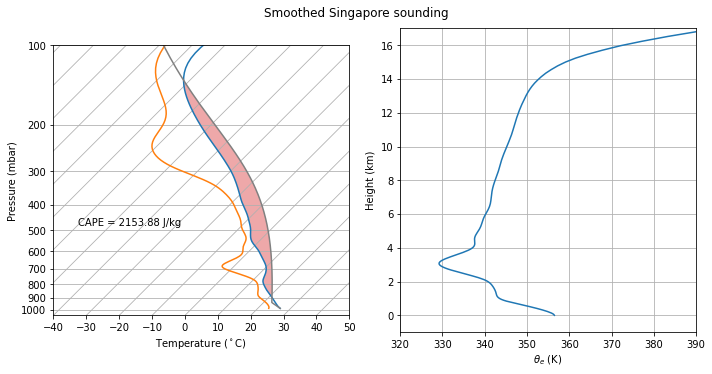

In [187]:
profile = mpcalc.parcel_profile(pressure, temperature[0], dewpoint[0])
cape, cin = mpcalc.cape_cin(pressure, temperature, dewpoint, profile)
theta_e = equivalent_potential_temperature(
    pressure, temperature, specific_humidity)

fig = plt.figure(figsize=(10,5))
skew = SkewT(fig, rotation=45, subplot=(1, 2, 1))
skew.plot(pressure, temperature)
skew.plot(pressure, dewpoint)
skew.plot(pressure, profile, '0.5')
skew.shade_cape(pressure, temperature, profile)
skew.ax.text(-60, 480, 'CAPE = {:.2f} J/kg'.format(cape.m))
skew.ax.set(ylabel='Pressure (mbar)', xlabel='Temperature ($^\circ$C)')

ax = fig.add_subplot(122)
ax.plot(theta_e, height.to(units.km))
ax.grid()
ax.set_xlim(320, 390)
ax.set_ylim(-1, 17)
ax.set(xlabel='$\\theta_e$ (K)', ylabel='Height (km)')
fig.tight_layout()
fig.suptitle('Smoothed Singapore sounding', y=1.03)

In [188]:
df = WyomingUpperAir.request_data(datetime(2021, 12, 21, 0), '94776')
df = df.dropna().drop(range(1))
sounding = df[['pressure', 'height', 'temperature', 'dewpoint']].to_numpy()

pressure_raw = sounding[:,0]
height_raw = sounding[:,1]
height_raw -= np.min(height_raw)
temperature_raw = sounding[:,2]
dewpoint_raw = sounding[:,3]

pressure = np.arange(pressure_raw[0], pressure_raw[-1], -5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)

temperature, specific_humidity = smooth_sounding(
    pressure, temperature, specific_humidity)
dewpoint = mpcalc.dewpoint_from_specific_humidity(
    pressure, temperature, specific_humidity)

williamtown_smoothed = CoupledThermalGenerator(
    np.flip(pressure), np.flip(height), np.flip(temperature),
    np.flip(specific_humidity))

Text(0.5, 1.03, 'Smoothed Williamtown sounding')

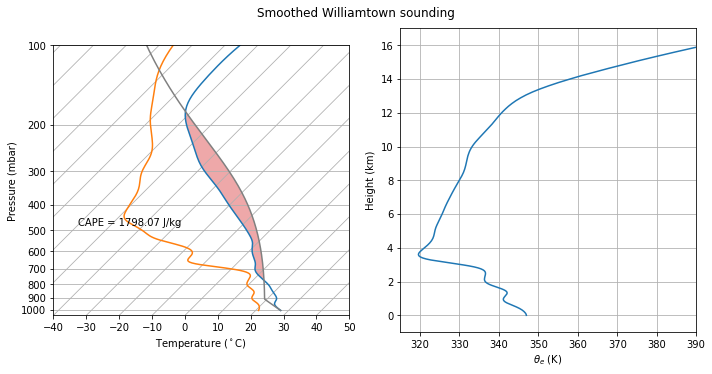

In [190]:
profile = mpcalc.parcel_profile(pressure, temperature[0], dewpoint[0])
cape, cin = mpcalc.cape_cin(pressure, temperature, dewpoint, profile)
theta_e = equivalent_potential_temperature(
    pressure, temperature, specific_humidity)

fig = plt.figure(figsize=(10,5))
skew = SkewT(fig, rotation=45, subplot=(1, 2, 1))
skew.plot(pressure, temperature)
skew.plot(pressure, dewpoint)
skew.plot(pressure, profile, '0.5')
skew.shade_cape(pressure, temperature, profile)
skew.ax.text(-60, 480, 'CAPE = {:.2f} J/kg'.format(cape.m))
skew.ax.set(ylabel='Pressure (mbar)', xlabel='Temperature ($^\circ$C)')

ax = fig.add_subplot(122)
ax.plot(theta_e, height.to(units.km))
ax.grid()
ax.set_xlim(315, 390)
ax.set_ylim(-1, 17)
ax.set(xlabel='$\\theta_e$ (K)', ylabel='Height (km)')
fig.tight_layout()
fig.suptitle('Smoothed Williamtown sounding', y=1.03)

In [191]:
df = WyomingUpperAir.request_data(datetime(2021, 12, 7, 0), '91285')
df = df.dropna()
sounding = df[['pressure', 'height', 'temperature', 'dewpoint']].to_numpy()

pressure_raw = sounding[:,0]
height_raw = sounding[:,1]
height_raw -= np.min(height_raw)
temperature_raw = sounding[:,2]
dewpoint_raw = sounding[:,3]

pressure = np.arange(pressure_raw[0], pressure_raw[-1], -5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)

temperature, specific_humidity = smooth_sounding(
    pressure, temperature, specific_humidity)
dewpoint = mpcalc.dewpoint_from_specific_humidity(
    pressure, temperature, specific_humidity)

hilo_smoothed = CoupledThermalGenerator(
    np.flip(pressure), np.flip(height), np.flip(temperature),
    np.flip(specific_humidity))

/Users/z5310829/opt/miniconda3/envs/notebooks/lib/python3.9/site-packages/metpy/calc/thermo.py:1061: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')


Text(0.5, 1.03, 'Smoothed Hilo sounding')

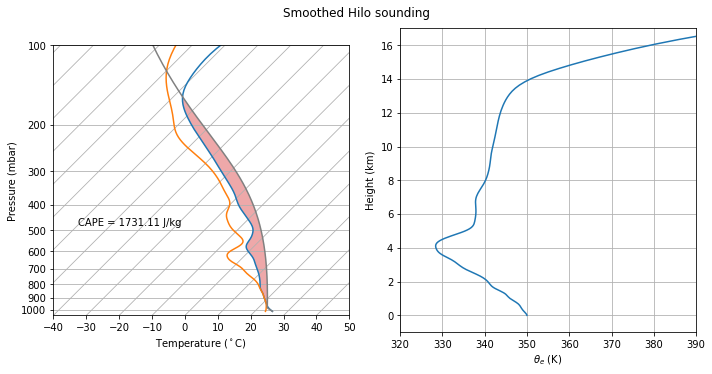

In [192]:
profile = mpcalc.parcel_profile(pressure, temperature[0], dewpoint[0])
cape, cin = mpcalc.cape_cin(pressure, temperature, dewpoint, profile)
theta_e = equivalent_potential_temperature(
    pressure, temperature, specific_humidity)

fig = plt.figure(figsize=(10,5))
skew = SkewT(fig, rotation=45, subplot=(1, 2, 1))
skew.plot(pressure, temperature)
skew.plot(pressure, dewpoint)
skew.plot(pressure, profile, '0.5')
skew.shade_cape(pressure, temperature, profile)
skew.ax.text(-60, 480, 'CAPE = {:.2f} J/kg'.format(cape.m))
skew.ax.set(ylabel='Pressure (mbar)', xlabel='Temperature ($^\circ$C)')

ax = fig.add_subplot(122)
ax.plot(theta_e, height.to(units.km))
ax.grid()
ax.set_xlim(320, 390)
ax.set_ylim(-1, 17)
ax.set(xlabel='$\\theta_e$ (K)', ylabel='Height (km)')
fig.tight_layout()
fig.suptitle('Smoothed Hilo sounding', y=1.03)

In [193]:
df = WyomingUpperAir.request_data(datetime(2021, 1, 30, 12), '94120')
df = df.dropna()
sounding = df[['pressure', 'height', 'temperature', 'dewpoint']].to_numpy()

pressure_raw = sounding[:,0]
height_raw = sounding[:,1]
height_raw -= np.min(height_raw)
temperature_raw = sounding[:,2]
dewpoint_raw = sounding[:,3]

pressure = np.arange(pressure_raw[0], pressure_raw[-1], -5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)

temperature, specific_humidity = smooth_sounding(
    pressure, temperature, specific_humidity)
dewpoint = mpcalc.dewpoint_from_specific_humidity(
    pressure, temperature, specific_humidity)

darwin_smoothed = CoupledThermalGenerator(
    np.flip(pressure), np.flip(height), np.flip(temperature),
    np.flip(specific_humidity))

/Users/z5310829/opt/miniconda3/envs/notebooks/lib/python3.9/site-packages/metpy/calc/thermo.py:1061: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')


Text(0.5, 1.03, 'Smoothed Darwin sounding')

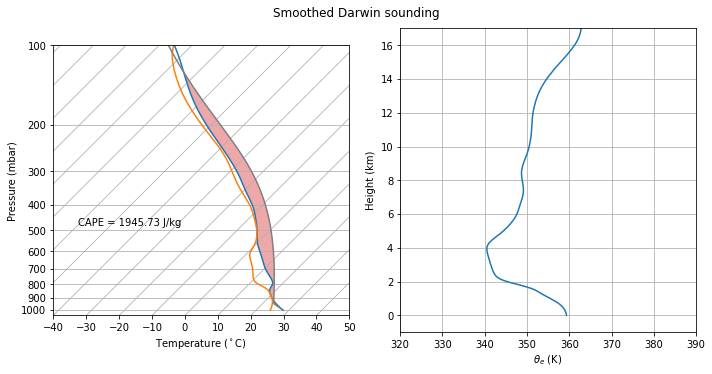

In [194]:
profile = mpcalc.parcel_profile(pressure, temperature[0], dewpoint[0])
cape, cin = mpcalc.cape_cin(pressure, temperature, dewpoint, profile)
theta_e = equivalent_potential_temperature(
    pressure, temperature, specific_humidity)

fig = plt.figure(figsize=(10,5))
skew = SkewT(fig, rotation=45, subplot=(1, 2, 1))
skew.plot(pressure, temperature)
skew.plot(pressure, dewpoint)
skew.plot(pressure, profile, '0.5')
skew.shade_cape(pressure, temperature, profile)
skew.ax.text(-60, 480, 'CAPE = {:.2f} J/kg'.format(cape.m))
skew.ax.set(ylabel='Pressure (mbar)', xlabel='Temperature ($^\circ$C)')

ax = fig.add_subplot(122)
ax.plot(theta_e, height.to(units.km))
ax.grid()
ax.set_xlim(320, 390)
ax.set_ylim(-1, 17)
ax.set(xlabel='$\\theta_e$ (K)', ylabel='Height (km)')
fig.tight_layout()
fig.suptitle('Smoothed Darwin sounding', y=1.03)

We now repeat the original comparison of the four soundings, using the smoothed data.

In [195]:
%%time
multiple_downdraft_runs(
    singapore_smoothed, 'singapore_smoothed', thickness, t_pert,
    l_crit, drag_up, drag_down)

Starting run singapore_smoothed ...
    epsilon_up = 0.10 /km ...
        Calculation 896 of 896    
    epsilon_up = 0.30 /km ...
        Calculation 896 of 896    
    epsilon_up = 0.50 /km ...
        Calculation 896 of 896    
CPU times: user 5min 31s, sys: 1.75 s, total: 5min 33s
Wall time: 5min 32s


In [196]:
%%time
multiple_downdraft_runs(
    williamtown_smoothed, 'williamtown_smoothed', thickness, t_pert,
    l_crit, drag_up, drag_down)

Starting run williamtown_smoothed ...
    epsilon_up = 0.10 /km ...
        Calculation 896 of 896    
    epsilon_up = 0.30 /km ...
        Calculation 896 of 896    
    epsilon_up = 0.50 /km ...
        Calculation 896 of 896    
CPU times: user 5min 55s, sys: 1.53 s, total: 5min 56s
Wall time: 5min 56s


In [184]:
%%time
multiple_downdraft_runs(
    hilo_smoothed, 'hilo_smoothed', thickness, t_pert,
    l_crit, drag_up, drag_down)

Starting run hilo_smoothed ...
    epsilon_up = 0.10 /km ...
        Calculation 924 of 924    
    epsilon_up = 0.30 /km ...
        Calculation 924 of 924    
    epsilon_up = 0.50 /km ...
        Calculation 924 of 924    
CPU times: user 5min 54s, sys: 1.78 s, total: 5min 55s
Wall time: 5min 56s


In [197]:
%%time
multiple_downdraft_runs(
    darwin_smoothed, 'darwin_smoothed', thickness, t_pert,
    l_crit, drag_up, drag_down)

Starting run darwin_smoothed ...
    epsilon_up = 0.10 /km ...
        Calculation 896 of 896    
    epsilon_up = 0.30 /km ...
        Calculation 896 of 896    
    epsilon_up = 0.50 /km ...
        Calculation 896 of 896    
CPU times: user 5min 41s, sys: 2.01 s, total: 5min 43s
Wall time: 5min 44s


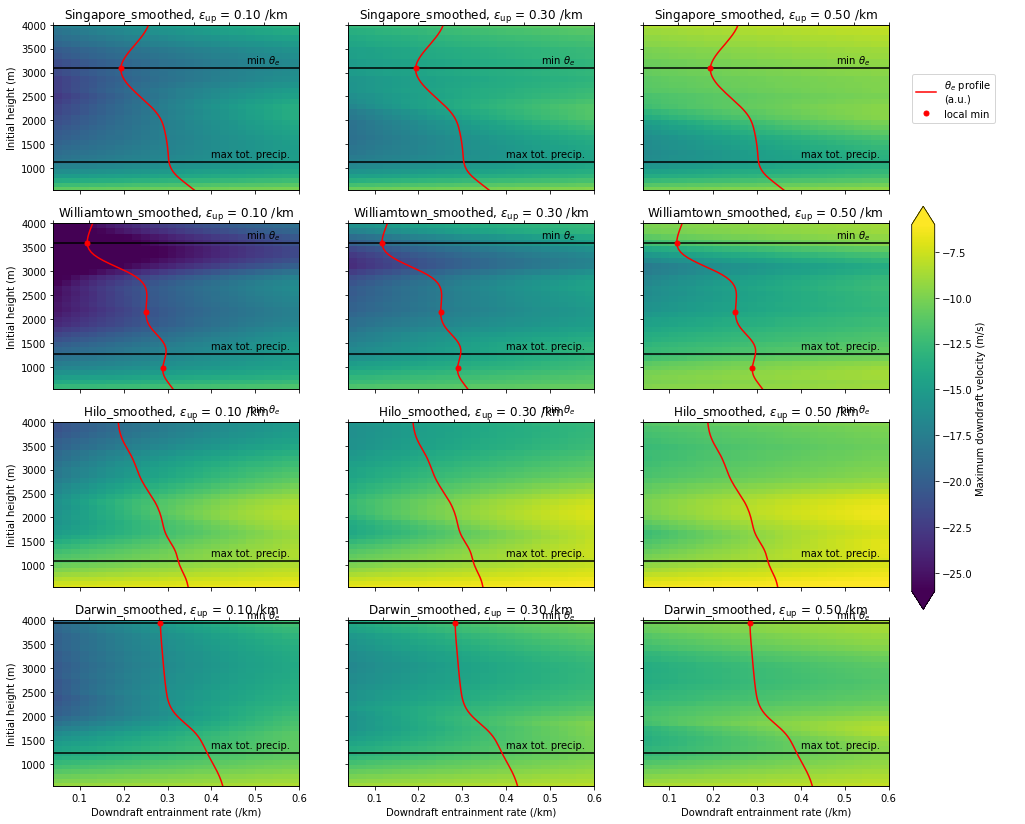

In [201]:
fig, axes = plt.subplots(4, 3, figsize=(16,14))

for i, name in enumerate([
        'singapore_smoothed', 'williamtown_smoothed',
        'hilo_smoothed', 'darwin_smoothed']):
    db = shelve.open('generalising_coupling_data/' + name)
    sounding = {'singapore_smoothed': singapore_smoothed,
                'williamtown_smoothed': williamtown_smoothed,
                'hilo_smoothed': hilo_smoothed,
                'darwin_smoothed': darwin_smoothed}[name]
    theta_e = equivalent_potential_temperature(
        sounding.pressure, sounding.temperature, sounding.specific_humidity)
    i_relmin_theta_e = argrelmin(theta_e, order=4)
    for j, eps in enumerate(epsilon_up):
        mesh = axes[i,j].pcolormesh(
            epsilon_down, db['z_init_down'], db['w_max'][j], shading='nearest')
        mesh.set_clim(-26, -6)
        
        axes[i,j].axhline(db['z_max_evap'][j].m, color='k')
        axes[i,j].text(0.4, db['z_max_evap'][j].m + 100, 'max tot. precip.')
        axes[i,j].axhline(db['z_min_theta_e'].m, color='k')
        axes[i,j].text(0.48, db['z_min_theta_e'].m + 100,
                       'min $\\theta_e$', color='k')
        
        ax = axes[i,j].twiny()
        ax.plot(theta_e, sounding.height,
                label='$\\theta_e$ profile\n(a.u.)', color='r')
        ax.plot(theta_e[i_relmin_theta_e], sounding.height[i_relmin_theta_e],
                'r.', markersize=10, label='local min')
        ax.set_xlim(310, 380)
        ax.set_xlabel('')
        ax.set_xticklabels([])
        
        title = (name.capitalize()
                 + r', $\epsilon_\mathrm{{up}}$ = {:.2f} /km'.format(eps.m))
        axes[i,j].set(xlabel='Downdraft entrainment rate (/km)',
                      ylabel='Initial height (m)',
                      title=title)
        axes[i,j].set_ylim(540, 4000)
    db.close()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.89, 0.85))
    
for ax in axes[:,1:].ravel():
    ax.set_ylabel('')
    ax.set_yticklabels([])
for ax in axes[:-1,:].ravel():
    ax.set_xlabel('')
    ax.set_xticklabels([])
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.3, 0.02, 0.4])
cbar = fig.colorbar(mesh, cax=cbar_ax, extend='both')
cbar.set_label('Maximum downdraft velocity (m/s)')

# fig.tight_layout()

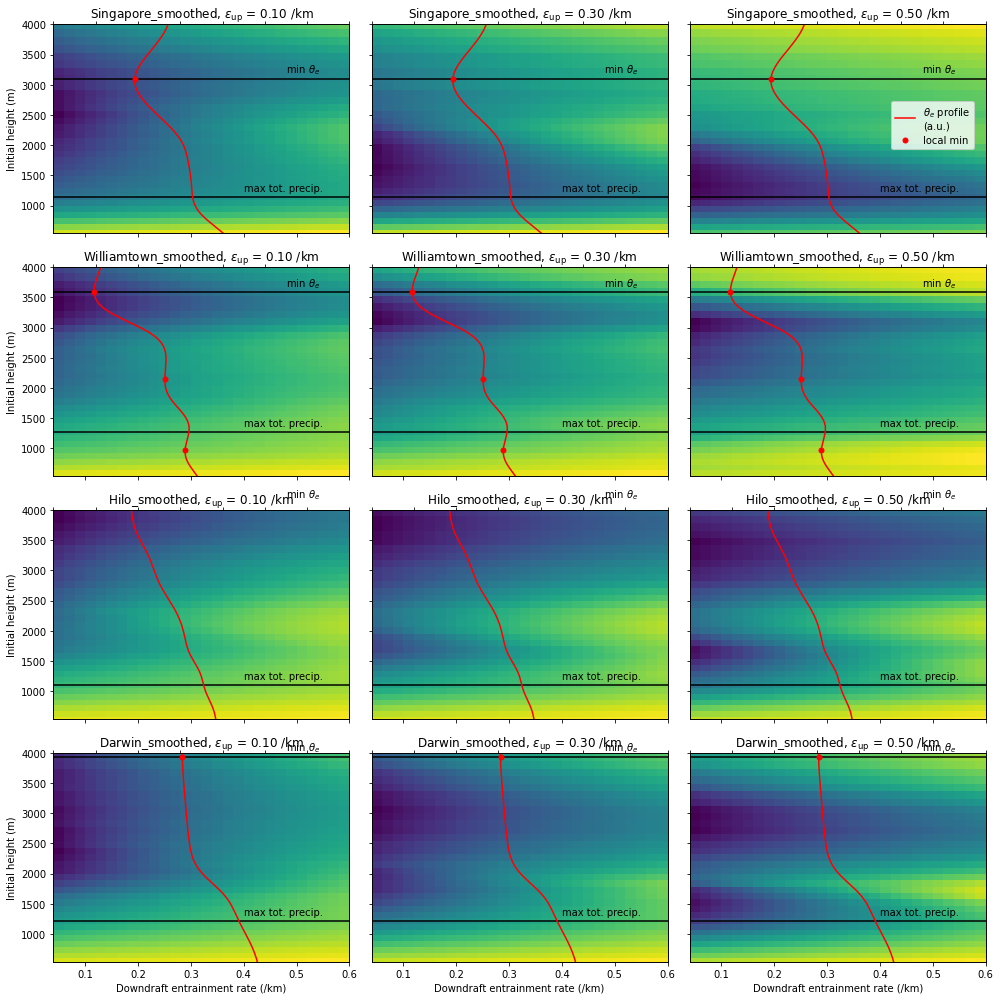

In [208]:
fig, axes = plt.subplots(4, 3, figsize=(14,14))

for i, name in enumerate([
        'singapore_smoothed', 'williamtown_smoothed',
        'hilo_smoothed', 'darwin_smoothed']):
    db = shelve.open('generalising_coupling_data/' + name)
    sounding = {'singapore_smoothed': singapore_smoothed,
                'williamtown_smoothed': williamtown_smoothed,
                'hilo_smoothed': hilo_smoothed,
                'darwin_smoothed': darwin_smoothed}[name]
    theta_e = equivalent_potential_temperature(
        sounding.pressure, sounding.temperature, sounding.specific_humidity)
    i_relmin_theta_e = argrelmin(theta_e, order=4)
    for j, eps in enumerate(epsilon_up):
        mesh = axes[i,j].pcolormesh(
            epsilon_down, db['z_init_down'], db['w_max'][j], shading='nearest')
        # mesh.set_clim(-26, -6)
        
        axes[i,j].axhline(db['z_max_evap'][j].m, color='k')
        axes[i,j].text(0.4, db['z_max_evap'][j].m + 100, 'max tot. precip.')
        axes[i,j].axhline(db['z_min_theta_e'].m, color='k')
        axes[i,j].text(0.48, db['z_min_theta_e'].m + 100,
                       'min $\\theta_e$', color='k')
        
        ax = axes[i,j].twiny()
        ax.plot(theta_e, sounding.height,
                label='$\\theta_e$ profile\n(a.u.)', color='r')
        ax.plot(theta_e[i_relmin_theta_e], sounding.height[i_relmin_theta_e],
                'r.', markersize=10, label='local min')
        ax.set_xlim(310, 380)
        ax.set_xlabel('')
        ax.set_xticklabels([])
        
        title = (name.capitalize()
                 + r', $\epsilon_\mathrm{{up}}$ = {:.2f} /km'.format(eps.m))
        axes[i,j].set(xlabel='Downdraft entrainment rate (/km)',
                      ylabel='Initial height (m)',
                      title=title)
        axes[i,j].set_ylim(540, 4000)
    db.close()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.89, 0.85))
    
for ax in axes[:,1:].ravel():
    ax.set_ylabel('')
    ax.set_yticklabels([])
for ax in axes[:-1,:].ravel():
    ax.set_xlabel('')
    ax.set_xticklabels([])
    
fig.tight_layout()

Above: the same plot, but with each subplot having its own colour scale to make features easier to see.

### Discussion
- The smoothing has made the downdraft strength less sensitive to small changes in initiation height. This is particularly evident in the Hilo sounding, whose results are now much smoother.
- The maxima in downdraft strength tend to shift to lower levels as updraft entrainment increases (due to decreasing precipitation availability at higher levels)

Unexplained observations:
- In the Williamtown sounding, the level of minimum $\theta_e$ has moved upwards as a result of the smoothing, but the corresponding level of maximum downdraft strength has not moved with it.
- In the Hilo and Darwin soundings, which have monotonically decreasing $\theta_e$ profiles, a clear two-peak structure appears as updraft entrainment rate increases.
    - This does not occur in the other soundings, whose $\theta_e$ profiles are not monotonic.